In [2]:
%run talktools.py
%matplotlib inline

<IPython.core.display.HTML object>

# The code is too slow. How to speed up?

#    

> Yixin Mao

> Feb 6, 2018

> Python Seminar

<i>Much of this material was prepared together with Elizabeth Clark</i>

# Steps

- Identify bottlenecks - which part of the code is slow?
    - <span style="color:green">**Time each code section**</span>
    - CPU v.s. I/O limit

- Strategies
    - Avoid loops
    - Parellel computing using Python

# Time each code section

In [10]:
''' This script generates a fake precipitation field. '''

import numpy as np
import xarray as xr
import pandas as pd

def generate_constant_precip_field(lats, lons, constant_precip):
    precip = np.ones([len(lats), len(lons)]) * constant_precip
    da_precip = xr.DataArray(precip,
                             coords=[lats, lons],
                             dims=['lat', 'lon'])
    return da_precip

def add_random_noise(da_precip_constant, std): 
    da_precip = da_precip_constant.copy()
    for lat in da_precip_constant['lat']:
        for lon in da_precip_constant['lon']:
            noise = np.random.normal(loc=0, scale=std)
            da_precip.loc[lat, lon] += noise
    return da_precip

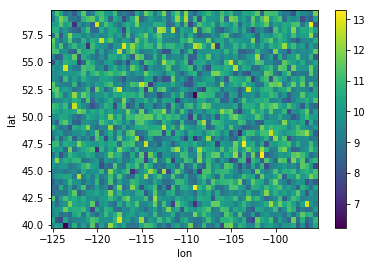

In [11]:
np.random.seed(3333)

# --- Step 1. generate constant field --- #
lats = np.arange(40, 60, 0.5)
lons = np.arange(-125, -95, 0.5)
da_precip_constant = generate_constant_precip_field(
    lats, lons, constant_precip=10)

# --- Step 2. add random noise to the constant precip field --- #
da_precip = add_random_noise(da_precip_constant, std=1)

da_precip.plot()

## Timing method 1: timeit

In [12]:
import timeit
np.random.seed(3333)

# --- Step 1. generate constant field --- #
time1 = timeit.default_timer()
lats = np.arange(40, 60, 0.5)
lons = np.arange(-125, -95, 0.5)
da_precip_constant = generate_constant_precip_field(
    lats, lons, constant_precip=10)
time2 = timeit.default_timer()
print('Time of step 1: {:.5} seconds'.format(time2-time1))

# --- Step 2. add random noise to the constant precip field --- #
time1 = timeit.default_timer()
da_precip = add_random_noise(da_precip_constant, std=1)
time2 = timeit.default_timer()
print('Time of step 2: {:.5} seconds'.format(time2-time1))

Time of step 1: 0.00048014 seconds
Time of step 2: 4.7296 seconds


## Timing method 2: line_profiler
(https://pypi.python.org/pypi/line_profiler/)
- Install line_profiler for Python: <span style="color:green">$ pip install line_profiler</span>
- Add @profile in front of each function you want to time:

In [ ]:
# my_code.py

@profile
def generate_constant_precip_field(lats, lons, constant_precip):
    precip = np.ones([len(lats), len(lons)]) * constant_precip
    da_precip = xr.DataArray(precip,
                             coords=[lats, lons],
                             dims=['lat', 'lon'])
    return da_precip

@profile
def add_random_noise(da_precip_constant, std):
    da_precip = da_precip_constant.copy()
    for lat in da_precip_constant['lat']:
        for lon in da_precip_constant['lon']:
            noise = np.random.normal(loc=0, scale=std)
            da_precip.loc[lat, lon] += noise
    return da_precip

Run script on command line: <span style="color:green">$ kernprof -l -v my_code.py</span>

Output on screen:

<img src="../figures/line_profiler_output.png">

# Steps

- Identify bottlenecks - which part of the code is slow?
    - Time each code section
    - <span style="color:green">**CPU v.s. I/O limit**</span>

- Strategies
    - Avoid loops
    - Parellel computing using Python

- If I/O is slowing you down, speeding up computation won’t help!

- *Example*: monitor CPU, I/O and memory usage on Hyak

    https://depts.washington.edu/hyak/ganglia/
    
- Options to limit I/O:
    - Keep more data in memory
    - Use binary file formats like netCDF or raw binary

# Steps

- Identify bottlenecks - which part of the code is slow?
    - Time each code section
    - CPU v.s. I/O limit

- Strategies
    - <span style="color:green">**Avoid loops**</span>
    - Parellel computing using Python

# Avoid loops - strategies

In [13]:
def add_random_noise(da_precip_constant, std):
    da_precip = da_precip_constant.copy()
    for lat in da_precip_constant['lat']:
        for lon in da_precip_constant['lon']:
            noise = np.random.normal(loc=0, scale=std)
            da_precip.loc[lat, lon] += noise
    return da_precip

time1 = timeit.default_timer()
da_precip = add_random_noise(da_precip_constant, std=1)
time2 = timeit.default_timer()
print('Time: {:.5} seconds'.format(time2-time1))

Time: 4.6258 seconds


# Avoid loops - use built-in functionailty

In [14]:
def add_random_noise_v2(da_precip_constant, std):
    da_precip = da_precip_constant.copy()
    noise = np.random.normal(
        loc=0, scale=std,
        size=(len(da_precip_constant['lat']),
              len(da_precip_constant['lon'])))
    da_precip[:] += noise
    return da_precip

time1 = timeit.default_timer()
da_precip = add_random_noise_v2(da_precip_constant, std=1)
time2 = timeit.default_timer()
print('Time: {:.5} seconds'.format(time2-time1))

Time: 0.0020235 seconds


# Avoid loops - use map() or apply()

In [15]:
def add_random_noise_v3(da_precip_constant, std):
    da_precip = da_precip_constant.copy()
    # Determine total number of loops
    nlat = len(da_precip_constant['lat'])
    nlon = len(da_precip_constant['lon'])
    nloop = nlat * nlon
    # Generate random noise using map()
    noise = np.array(list(map(np.random.normal,
                              np.zeros(nloop),
                              np.ones(nloop)*std))) # dimension: [nloop]
    # Reshape noise
    noise = noise.reshape([nlat, nlon])
    # Add noise to precipitation 
    da_precip[:] += noise
    return da_precip

time1 = timeit.default_timer()
da_precip = add_random_noise_v3(da_precip_constant, std=1)
time2 = timeit.default_timer()
print('Time: {:.5} seconds'.format(time2-time1))

Time: 0.0093645 seconds


# Avoid loops

- Use built-in functionality
- map() or apply()
- List comprehension: `[f(x) for x in x_array]`
- itertools
- numpy.fromfunction()

# Steps

- Identify bottlenecks - which part of the code is slow?
    - Time each code section
    - CPU v.s. I/O limit

- Strategies
    - Avoid loops
    - <span style="color:green">**Parellel computing using Python**</span>

# Python multiprocessing package - "multi-task" on one machine

In [16]:
import time

def do_some_task(input_var):
    # Some slow task
    time.sleep(2)
    print(input_var)

for i in range(0, 5):
    do_some_task(i)

0
1
2
3
4


# With multiprocessing

In [ ]:
import multiprocessing as mp

# Set up multiprocessing
pool = mp.Pool(processes=5)
# Loop over tasks
for i in range(5):
    pool.apply_async(do_some_task, (i,))
# Finish multiprocessing
pool.close()
pool.join()

- <span style="color:green">will print *ALL* numbers in ~ 2 seconds</span>


- multiprocessing works the best in script mode
- there may be some issues in Jupyter Notebook (at least on Windows)

# Using multiple nodes: mpi4py

- More than 1 node: distributed memory

- Nodes do not have access to same data, must tell program what info and when to share 
    
- MPI = Message Passing Interface

In [ ]:
# my_script.py

from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = MPI.COMM_WORLD.Get_rank()

a = 6.0
b = 3.0
if rank == 0:
        print(a + b)
if rank == 1:
        print(a * b)
if rank == 2:
        print(max(a, b))

$ mpiexec  -n 5 python  hello.py

In [ ]:
# my_script.py

import numpy
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

a = 6.0
b = 3.0
if rank == 0:
        comm.Send(a + b, dest=1)
if rank == 1:
        print(a * b)
        comm.Recv(c)
        print(c)
if rank == 2:
        print(max(a, b))

# Thank you!

yixinmao@uw.edu

(The interactive slides are enabled by Python RISE package)